In [ ]:
#| default_exp models.dilated_rnn

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dilated RNN

The Dilated Recurrent Neural Network (`DilatedRNN`) addresses common challenges of modeling long sequences like vanishing gradients, computational efficiency, and improved model flexibility to model complex relationships while maintaining its parsimony. The `DilatedRNN` builds a deep stack of RNN layers using skip conditions on the temporal and the network's depth dimensions. The temporal dilated recurrent skip connections offer the capability to focus on multi-resolution inputs.The predictions are obtained by transforming the hidden states into contexts $\mathbf{c}_{[t+1:t+H]}$, that are decoded and adapted into $\mathbf{\hat{y}}_{[t+1:t+H],[q]}$ through MLPs.

\begin{align}
 \mathbf{h}_{t} &= \textrm{DilatedRNN}([\mathbf{y}_{t},\mathbf{x}^{(h)}_{t},\mathbf{x}^{(s)}], \mathbf{h}_{t-1})\\
\mathbf{c}_{[t+1:t+H]}&=\textrm{Linear}([\mathbf{h}_{t}, \mathbf{x}^{(f)}_{[:t+H]}]) \\ 
\hat{y}_{\tau,[q]}&=\textrm{MLP}([\mathbf{c}_{\tau},\mathbf{x}^{(f)}_{\tau}])
\end{align}

where $\mathbf{h}_{t}$, is the hidden state for time $t$, $\mathbf{y}_{t}$ is the input at time $t$ and $\mathbf{h}_{t-1}$ is the hidden state of the previous layer at $t-1$, $\mathbf{x}^{(s)}$ are static exogenous inputs, $\mathbf{x}^{(h)}_{t}$ historic exogenous, $\mathbf{x}^{(f)}_{[:t+H]}$ are future exogenous available at the time of the prediction.

**References**<br>-[Shiyu Chang, et al. "Dilated Recurrent Neural Networks".](https://arxiv.org/abs/1710.02224)<br>-[Yao Qin, et al. "A Dual-Stage Attention-Based recurrent neural network for time series prediction".](https://arxiv.org/abs/1704.02971)<br>-[Kashif Rasul, et al. "Zalando Research: PyTorch Dilated Recurrent Neural Networks".](https://arxiv.org/abs/1710.02224)<br>

![Figure 1. Three layer DilatedRNN with dilation 1, 2, 4.](imgs_models/dilated_rnn.png)

In [ ]:
#| hide
import logging
import warnings
from nbdev.showdoc import show_doc
from neuralforecast.utils import generate_series
from neuralforecast.common._model_checks import check_model

In [ ]:
#| export
from typing import List, Optional

import torch
import torch.nn as nn

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_model import BaseModel
from neuralforecast.common._modules import MLP

In [ ]:
#| exporti
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weight_ih = nn.Parameter(torch.randn(4 * hidden_size, input_size))
        self.weight_hh = nn.Parameter(torch.randn(4 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.randn(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.randn(4 * hidden_size))
        self.dropout = dropout

    def forward(self, inputs, hidden):
        hx, cx = hidden[0].squeeze(0), hidden[1].squeeze(0)
        gates = (torch.matmul(inputs, self.weight_ih.t()) + self.bias_ih +
                         torch.matmul(hx, self.weight_hh.t()) + self.bias_hh)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * torch.tanh(cy)

        return hy, (hy, cy)

In [ ]:
#| exporti
class ResLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.):
        super(ResLSTMCell, self).__init__()
        self.register_buffer('input_size', torch.Tensor([input_size]))
        self.register_buffer('hidden_size', torch.Tensor([hidden_size]))
        self.weight_ii = nn.Parameter(torch.randn(3 * hidden_size, input_size))
        self.weight_ic = nn.Parameter(torch.randn(3 * hidden_size, hidden_size))
        self.weight_ih = nn.Parameter(torch.randn(3 * hidden_size, hidden_size))
        self.bias_ii = nn.Parameter(torch.randn(3 * hidden_size))
        self.bias_ic = nn.Parameter(torch.randn(3 * hidden_size))
        self.bias_ih = nn.Parameter(torch.randn(3 * hidden_size))
        self.weight_hh = nn.Parameter(torch.randn(1 * hidden_size, hidden_size))
        self.bias_hh = nn.Parameter(torch.randn(1 * hidden_size))
        self.weight_ir = nn.Parameter(torch.randn(hidden_size, input_size))
        self.dropout = dropout

    def forward(self, inputs, hidden):
        hx, cx = hidden[0].squeeze(0), hidden[1].squeeze(0)

        ifo_gates = (torch.matmul(inputs, self.weight_ii.t()) + self.bias_ii +
                                  torch.matmul(hx, self.weight_ih.t()) + self.bias_ih +
                                  torch.matmul(cx, self.weight_ic.t()) + self.bias_ic)
        ingate, forgetgate, outgate = ifo_gates.chunk(3, 1)

        cellgate = torch.matmul(hx, self.weight_hh.t()) + self.bias_hh

        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        ry = torch.tanh(cy)

        if self.input_size == self.hidden_size:
            hy = outgate * (ry + inputs)
        else:
            hy = outgate * (ry + torch.matmul(inputs, self.weight_ir.t()))
        return hy, (hy, cy)

In [ ]:
#| exporti
class ResLSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.):
        super(ResLSTMLayer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.cell = ResLSTMCell(input_size, hidden_size, dropout=0.)

    def forward(self, inputs, hidden):
        inputs = inputs.unbind(0)
        outputs = []
        for i in range(len(inputs)):
                out, hidden = self.cell(inputs[i], hidden)
                outputs += [out]
        outputs = torch.stack(outputs)
        return outputs, hidden

In [ ]:
#| exporti
class AttentiveLSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0):
        super(AttentiveLSTMLayer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        attention_hsize = hidden_size
        self.attention_hsize = attention_hsize

        self.cell = LSTMCell(input_size, hidden_size)
        self.attn_layer = nn.Sequential(nn.Linear(2 * hidden_size + input_size, attention_hsize),
                                        nn.Tanh(),
                                        nn.Linear(attention_hsize, 1))
        self.softmax = nn.Softmax(dim=0)
        self.dropout = dropout

    def forward(self, inputs, hidden):
        inputs = inputs.unbind(0)
        outputs = []

        for t in range(len(inputs)):
            # attention on windows
            hx, cx = (tensor.squeeze(0) for tensor in hidden)
            hx_rep = hx.repeat(len(inputs), 1, 1)
            cx_rep = cx.repeat(len(inputs), 1, 1)
            x = torch.cat((inputs, hx_rep, cx_rep), dim=-1)
            l = self.attn_layer(x)
            beta = self.softmax(l)
            context = torch.bmm(beta.permute(1, 2, 0),
                                inputs.permute(1, 0, 2)).squeeze(1)
            out, hidden = self.cell(context, hidden)
            outputs += [out]
        outputs = torch.stack(outputs)
        return outputs, hidden

In [ ]:
#| exporti
class DRNN(nn.Module):

    def __init__(self, n_input, n_hidden, n_layers, dilations, dropout=0, cell_type='GRU', batch_first=True):
        super(DRNN, self).__init__()

        self.dilations = dilations
        self.cell_type = cell_type
        self.batch_first = batch_first

        layers = []
        if self.cell_type == "GRU":
            cell = nn.GRU
        elif self.cell_type == "RNN":
            cell = nn.RNN
        elif self.cell_type == "LSTM":
            cell = nn.LSTM
        elif self.cell_type == "ResLSTM":
            cell = ResLSTMLayer
        elif self.cell_type == "AttentiveLSTM":
            cell = AttentiveLSTMLayer
        else:
            raise NotImplementedError

        for i in range(n_layers):
            if i == 0:
                c = cell(n_input, n_hidden, dropout=dropout)
            else:
                c = cell(n_hidden, n_hidden, dropout=dropout)
            layers.append(c)
        self.cells = nn.Sequential(*layers)

    def forward(self, inputs, hidden=None):
        if self.batch_first:
            inputs = inputs.transpose(0, 1)
        outputs = []
        for i, (cell, dilation) in enumerate(zip(self.cells, self.dilations)):
            if hidden is None:
                inputs, _ = self.drnn_layer(cell, inputs, dilation)
            else:
                inputs, hidden[i] = self.drnn_layer(cell, inputs, dilation, hidden[i])

            outputs.append(inputs[-dilation:])

        if self.batch_first:
            inputs = inputs.transpose(0, 1)
        return inputs, outputs

    def drnn_layer(self, cell, inputs, rate, hidden=None):
        n_steps = len(inputs)
        batch_size = inputs[0].size(0)
        hidden_size = cell.hidden_size

        inputs, dilated_steps = self._pad_inputs(inputs, n_steps, rate)
        dilated_inputs = self._prepare_inputs(inputs, rate)

        if hidden is None:
            dilated_outputs, hidden = self._apply_cell(dilated_inputs, cell, batch_size, rate, hidden_size)
        else:
            hidden = self._prepare_inputs(hidden, rate)
            dilated_outputs, hidden = self._apply_cell(dilated_inputs, cell, batch_size, rate, hidden_size,
                                                       hidden=hidden)

        splitted_outputs = self._split_outputs(dilated_outputs, rate)
        outputs = self._unpad_outputs(splitted_outputs, n_steps)

        return outputs, hidden

    def _apply_cell(self, dilated_inputs, cell, batch_size, rate, hidden_size, hidden=None):
        if hidden is None:
            hidden = torch.zeros(batch_size * rate, hidden_size,
                                 dtype=dilated_inputs.dtype,
                                 device=dilated_inputs.device)
            hidden = hidden.unsqueeze(0)
            
            if self.cell_type in ['LSTM', 'ResLSTM', 'AttentiveLSTM']:
                hidden = (hidden, hidden)
                
        dilated_outputs, hidden = cell(dilated_inputs, hidden) # compatibility hack

        return dilated_outputs, hidden

    def _unpad_outputs(self, splitted_outputs, n_steps):
        return splitted_outputs[:n_steps]

    def _split_outputs(self, dilated_outputs, rate):
        batchsize = dilated_outputs.size(1) // rate

        blocks = [dilated_outputs[:, i * batchsize: (i + 1) * batchsize, :] for i in range(rate)]

        interleaved = torch.stack((blocks)).transpose(1, 0)
        interleaved = interleaved.reshape(dilated_outputs.size(0) * rate,
                                       batchsize,
                                       dilated_outputs.size(2))
        return interleaved

    def _pad_inputs(self, inputs, n_steps, rate):
        iseven = (n_steps % rate) == 0

        if not iseven:
            dilated_steps = n_steps // rate + 1

            zeros_ = torch.zeros(dilated_steps * rate - inputs.size(0),
                                 inputs.size(1),
                                 inputs.size(2), 
                                 dtype=inputs.dtype,
                                 device=inputs.device)
            inputs = torch.cat((inputs, zeros_))
        else:
            dilated_steps = n_steps // rate

        return inputs, dilated_steps

    def _prepare_inputs(self, inputs, rate):
        dilated_inputs = torch.cat([inputs[j::rate, :, :] for j in range(rate)], 1)
        return dilated_inputs

In [ ]:
#| export
class DilatedRNN(BaseModel):
    """ DilatedRNN

    **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, maximum sequence length for truncated train backpropagation. Default -1 uses all history.<br>
    `inference_input_size`: int, maximum sequence length for truncated inference. Default -1 uses all history.<br>
    `cell_type`: str, type of RNN cell to use. Options: 'GRU', 'RNN', 'LSTM', 'ResLSTM', 'AttentiveLSTM'.<br>
    `dilations`: int list, dilations betweem layers.<br>
    `encoder_hidden_size`: int=200, units for the RNN's hidden state size.<br>
    `context_size`: int=10, size of context vector for each timestamp on the forecasting window.<br>
    `decoder_hidden_size`: int=200, size of hidden layer for the MLP decoder.<br>
    `decoder_layers`: int=2, number of layers for the MLP decoder.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int, maximum number of training steps.<br>
    `learning_rate`: float, Learning rate between (0, 1).<br>
    `num_lr_decays`: int, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
    `lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br> 
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    
    """
    # Class attributes
    EXOGENOUS_FUTR = True
    EXOGENOUS_HIST = True
    EXOGENOUS_STAT = True
    MULTIVARIATE = False    # If the model produces multivariate forecasts (True) or univariate (False)
    RECURRENT = False       # If the model produces forecasts recursively (True) or direct (False)

    def __init__(self,
                 h: int,
                 input_size: int,
                 inference_input_size: int = -1,
                 cell_type: str = 'LSTM',
                 dilations: List[List[int]] = [[1, 2], [4, 8]],
                 encoder_hidden_size: int = 128,
                 context_size: int = 10,
                 decoder_hidden_size: int = 128,
                 decoder_layers: int = 2,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 exclude_insample_y = False,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = 3,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size = 128,
                 inference_windows_batch_size = 1024,
                 start_padding_enabled = False,
                 step_size: int = 1,
                 scaler_type: str = 'robust',
                 random_seed: int = 1,
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 optimizer = None,
                 optimizer_kwargs = None,
                 lr_scheduler = None,
                 lr_scheduler_kwargs = None,
                 **trainer_kwargs):
        super(DilatedRNN, self).__init__(
            h=h,
            input_size=input_size,
            futr_exog_list=futr_exog_list,
            hist_exog_list=hist_exog_list,
            stat_exog_list=stat_exog_list,
            exclude_insample_y = exclude_insample_y,
            loss=loss,
            valid_loss=valid_loss,
            max_steps=max_steps,
            learning_rate=learning_rate,
            num_lr_decays=num_lr_decays,
            early_stop_patience_steps=early_stop_patience_steps,
            val_check_steps=val_check_steps,
            batch_size=batch_size,
            valid_batch_size=valid_batch_size,
            windows_batch_size=windows_batch_size,
            inference_windows_batch_size=inference_windows_batch_size,
            start_padding_enabled=start_padding_enabled,
            step_size=step_size,
            scaler_type=scaler_type,
            random_seed=random_seed,
            num_workers_loader=num_workers_loader,
            drop_last_loader=drop_last_loader,
            optimizer=optimizer,
            optimizer_kwargs=optimizer_kwargs,
            lr_scheduler=lr_scheduler,
            lr_scheduler_kwargs=lr_scheduler_kwargs,
            **trainer_kwargs
        )

        # Dilated RNN
        self.cell_type = cell_type
        self.dilations = dilations
        self.encoder_hidden_size = encoder_hidden_size
        
        # Context adapter
        self.context_size = context_size

        # MLP decoder
        self.decoder_hidden_size = decoder_hidden_size
        self.decoder_layers = decoder_layers

        # RNN input size (1 for target variable y)
        input_encoder = 1 + self.hist_exog_size + self.stat_exog_size + self.futr_exog_size

        # Instantiate model
        layers = []
        for grp_num in range(len(self.dilations)):
            if grp_num > 0:
                input_encoder = self.encoder_hidden_size
            layer = DRNN(input_encoder,
                         self.encoder_hidden_size,
                         n_layers=len(self.dilations[grp_num]),
                         dilations=self.dilations[grp_num],
                         cell_type=self.cell_type)
            layers.append(layer)

        self.rnn_stack = nn.Sequential(*layers)

        # Context adapter
        self.context_adapter = nn.Linear(in_features=self.input_size,
                                         out_features=h)

        # Decoder MLP
        self.mlp_decoder = MLP(in_features=self.encoder_hidden_size + self.futr_exog_size,
                               out_features=self.loss.outputsize_multiplier,
                               hidden_size=self.decoder_hidden_size,
                               num_layers=self.decoder_layers,
                               activation='ReLU',
                               dropout=0.0)

    def forward(self, windows_batch):
        
        # Parse windows_batch
        encoder_input = windows_batch['insample_y']                         # [B, L, 1]
        futr_exog     = windows_batch['futr_exog']                          # [B, L + h, F]
        hist_exog     = windows_batch['hist_exog']                          # [B, L, X]
        stat_exog     = windows_batch['stat_exog']                          # [B, S]

        # Concatenate y, historic and static inputs              
        batch_size, seq_len = encoder_input.shape[:2]
        if self.hist_exog_size > 0:
            encoder_input = torch.cat((encoder_input, hist_exog), dim=2)    # [B, L, 1] + [B, L, X] -> [B, L, 1 + X]

        if self.stat_exog_size > 0:
            stat_exog = stat_exog.unsqueeze(1).repeat(1, seq_len, 1)        # [B, S] -> [B, L, S]
            encoder_input = torch.cat((encoder_input, stat_exog), dim=2)    # [B, L, 1 + X] + [B, L, S] -> [B, L, 1 + X + S]

        if self.futr_exog_size > 0:
            encoder_input = torch.cat((encoder_input, 
                                       futr_exog[:, :seq_len]), dim=2)      # [B, L, 1 + X + S] + [B, L, F] -> [B, L, 1 + X + S + F]

        # DilatedRNN forward
        for layer_num in range(len(self.rnn_stack)):
            residual = encoder_input
            output, _ = self.rnn_stack[layer_num](encoder_input)
            if layer_num > 0:
                output += residual
            encoder_input = output

        # Context adapter
        output = output.permute(0, 2, 1)                                    # [B, L, C] -> [B, C, L]
        context = self.context_adapter(output)                              # [B, C, L] -> [B, C, h]

        # Residual connection with futr_exog
        if self.futr_exog_size > 0:
            futr_exog_futr = futr_exog[:, seq_len:].permute(0, 2, 1)        # [B, h, F] -> [B, F, h]
            context = torch.cat((context, futr_exog_futr), 
                                dim=1)                                      # [B, C, h] + [B, F, h] = [B, C + F, h]

        # Final forecast
        context = context.permute(0, 2, 1)                                  # [B, C + F, h] -> [B, h, C + F]
        output = self.mlp_decoder(context)                                  # [B, h, C + F] -> [B, h, n_output]
        
        return output

In [ ]:
show_doc(DilatedRNN)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/dilated_rnn.py#L289){target="_blank" style="float:right; font-size:smaller"}

### DilatedRNN

>      DilatedRNN (h:int, input_size:int, inference_input_size:int=-1,
>                  cell_type:str='LSTM', dilations:List[List[int]]=[[1, 2], [4,
>                  8]], encoder_hidden_size:int=200, context_size:int=10,
>                  decoder_hidden_size:int=200, decoder_layers:int=2,
>                  futr_exog_list=None, hist_exog_list=None,
>                  stat_exog_list=None, exclude_insample_y=False, loss=MAE(),
>                  valid_loss=None, max_steps:int=1000,
>                  learning_rate:float=0.001, num_lr_decays:int=3,
>                  early_stop_patience_steps:int=-1, val_check_steps:int=100,
>                  batch_size=32, valid_batch_size:Optional[int]=None,
>                  windows_batch_size=1024, inference_windows_batch_size=1024,
>                  start_padding_enabled=False, step_size:int=1,
>                  scaler_type:str='robust', random_seed:int=1,
>                  num_workers_loader:int=0, drop_last_loader:bool=False,
>                  optimizer=None, optimizer_kwargs=None, lr_scheduler=None,
>                  lr_scheduler_kwargs=None, **trainer_kwargs)

*DilatedRNN

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`input_size`: int, maximum sequence length for truncated train backpropagation. Default -1 uses all history.<br>
`inference_input_size`: int, maximum sequence length for truncated inference. Default -1 uses all history.<br>
`cell_type`: str, type of RNN cell to use. Options: 'GRU', 'RNN', 'LSTM', 'ResLSTM', 'AttentiveLSTM'.<br>
`dilations`: int list, dilations betweem layers.<br>
`encoder_hidden_size`: int=200, units for the RNN's hidden state size.<br>
`context_size`: int=10, size of context vector for each timestamp on the forecasting window.<br>
`decoder_hidden_size`: int=200, size of hidden layer for the MLP decoder.<br>
`decoder_layers`: int=2, number of layers for the MLP decoder.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int, maximum number of training steps.<br>
`learning_rate`: float, Learning rate between (0, 1).<br>
`num_lr_decays`: int, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int, Number of validation iterations before early stopping.<br>
`val_check_steps`: int, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of different series in each batch.<br>
`valid_batch_size`: int=None, number of different series in each validation and test batch.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
`optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
`lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
`lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br> 
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>*

In [ ]:
show_doc(DilatedRNN.fit, name='DilatedRNN.fit')

---

### DilatedRNN.fit

>      DilatedRNN.fit (dataset, val_size=0, test_size=0, random_seed=None,
>                      distributed_config=None)

*Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`test_size`: int, test size for temporal cross-validation.<br>*

In [ ]:
show_doc(DilatedRNN.predict, name='DilatedRNN.predict')

---

### DilatedRNN.predict

>      DilatedRNN.predict (dataset, test_size=None, step_size=1,
>                          random_seed=None, **data_module_kwargs)

*Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).*

In [ ]:
#| hide
# Unit tests for models
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("lightning_fabric").setLevel(logging.ERROR)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    check_model(DilatedRNN, ["airpassengers"])

DilatedRNN: checking forecast AirPassengers dataset


## Usage Example

c:\Users\ospra\OneDrive\Nixtla\Repositories\neuralforecast\neuralforecast\common\_base_model.py:134: UserWarning: Input size too small. Automatically setting input size to 3 * horizon = 36
  warnings.warn(


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\ospra\OneDrive\Nixtla\Repositories\neuralforecast\neuralforecast\core.py:213: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


[]

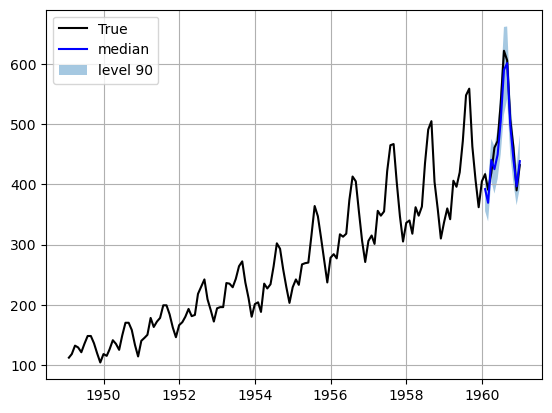

In [ ]:
#| eval: false
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import DilatedRNN
from neuralforecast.losses.pytorch import DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

fcst = NeuralForecast(
    models=[DilatedRNN(h=12,
                       input_size=-1,
                       loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                       scaler_type='robust',
                       encoder_hidden_size=100,
                       max_steps=200,
                       futr_exog_list=['y_[lag12]'],
                       hist_exog_list=None,
                       stat_exog_list=['airline1'],
    )
    ],
    freq='M'
)
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic)
forecasts = fcst.predict(futr_df=Y_test_df)

Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['DilatedRNN-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['DilatedRNN-lo-90'][-12:].values, 
                 y2=plot_df['DilatedRNN-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()